In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch_geometric as G
import torch_geometric.nn as gnn
from torch_geometric import transforms, utils


import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm, trange

import data
from shot import  SHOTDescriptor
from rops import ROPSDescriptor
from utils import PosAsX, SetTarget

In [4]:
DATA_PATH="/scratch/local/ssd/nhat/data/"
BATCH_SIZE = 256

torch.manual_seed(2024)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
    
random_transform = transforms.Compose(
    [
        transforms.RandomRotate(180, 0),
        transforms.RandomRotate(180, 1),
        transforms.RandomRotate(180, 2),
    ]
)

In [32]:
gshape_train = G.datasets.GeometricShapes(
    root=DATA_PATH,
    train=True,
    transform=transforms.Compose([PosAsX(), transforms.FaceToEdge(), random_transform]),
)
gshape_val = G.datasets.GeometricShapes(
    root=DATA_PATH,
    train=False,
    transform=transforms.Compose([PosAsX(), transforms.FaceToEdge(), random_transform]),
)
gshape_train_loader = G.loader.DataLoader(
    gshape_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)
gshape_val_loader = G.loader.DataLoader(
    gshape_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)

In [33]:
qm9_label_idx = 0
qm9 = G.datasets.QM9(
    root=DATA_PATH, transform=transforms.Compose([SetTarget(qm9_label_idx)])
)
qm9_train_loader = G.loader.DataLoader(
    qm9, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0
)
qm9_val_loader = G.loader.DataLoader(
    qm9, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0
)

In [5]:
qm9_train_loader, qm9_val_loader, _ = data.qm9(DATA_PATH, batch_size=4)

In [6]:
batch = next(iter(qm9_train_loader))

In [74]:
shot_2, lrfs_2 = shot, lrfs

In [84]:
x = torch.randn(2, 3, 3)
x

tensor([[[-0.2297, -0.8222,  0.7455],
         [-0.6128, -1.2249, -0.0590],
         [-0.7325, -0.0890,  0.1598]],

        [[ 2.1308, -0.9396,  1.0113],
         [ 0.8563, -1.0460,  1.9405],
         [-0.8371,  0.6557, -1.7986]]])

In [92]:
idx = torch.ones(2, 3, 4, dtype=torch.int)

In [93]:
x[:, :, idx].shape

torch.Size([2, 3, 2, 3, 4])

In [13]:
shot, lrfs = SHOTDescriptor()(batch.pos, batch.batch, return_lrfs=True)

In [10]:
rops, lrfs = ROPSDescriptor()(batch.pos, batch.batch, return_lrfs=True)

torch.Size([4, 22, 6])
torch.Size([4, 22, 6])
torch.Size([4, 22, 6])
torch.Size([4, 22, 6, 12])


In [12]:
rops.shape

torch.Size([82, 72])

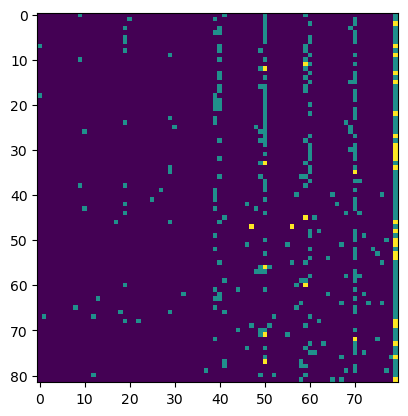

In [14]:
plt.imshow(shot)
plt.show()

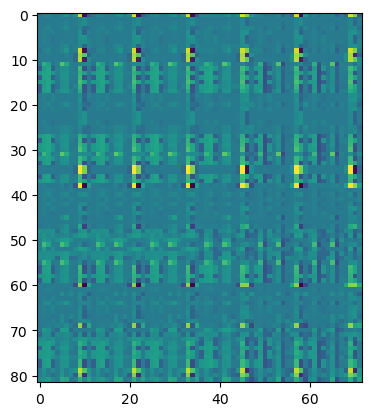

In [11]:
plt.imshow(rops)

In [111]:
shot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [114]:
torch.allclose(shot, shot_2)

True

In [106]:
shot.shape

torch.Size([76, 80])

In [72]:
(torch.randn([4, 4, 3, 5]) @ torch.randn(4, 4, 5, 7)).shape
# torch.bmm(torch.randn([4, 4, 3, 3]), torch.randn(4, 4, 3, 3))

torch.Size([4, 4, 3, 7])

In [63]:
batch.x.shape

torch.Size([76, 11])

In [62]:
shot.shape

torch.Size([76, 80])

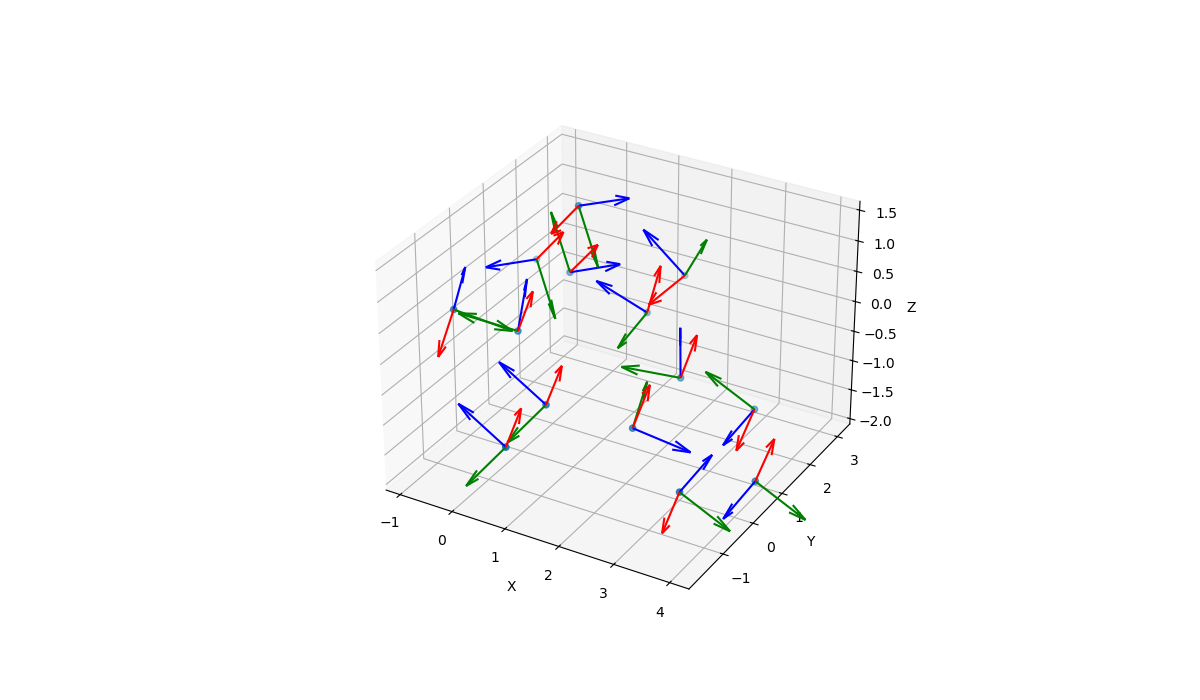

In [49]:
xs, ys, zs = [batch.pos[:, i] for i in range(3)]
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.quiver(xs, ys, zs, lrfs[0, :, 0, 0], lrfs[0, :, 1, 0], lrfs[0, :, 2, 0], length=1, color="r")
ax.quiver(xs, ys, zs, lrfs[0, :, 0, 1], lrfs[0, :, 1, 1], lrfs[0, :, 2, 1], length=1, color="g")
ax.quiver(xs, ys, zs, lrfs[0, :, 0, 2], lrfs[0, :, 1, 2], lrfs[0, :, 2, 2], length=1, color="b")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [42]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0, skip=0):
        super().__init__()
        self.gconvs = torch.nn.ModuleList()
        dims = [input_dim] + hidden_dim
        for i in range(1, len(dims)):
            self.gconvs.append(gnn.GCNConv(dims[i-1], dims[i]))
        self.logit = nn.Linear(dims[-1], output_dim)
        self.dropout = dropout
        self.skip = skip

    def forward(self, x, edge_index, batch):
        for i, l in enumerate(self.gconvs):
            prev_x = x
            x = l(x, edge_index)
            x = F.relu(x)
            
            if self.skip != 0 and i % self.skip == 0:
                x += prev_x
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = gnn.global_mean_pool(x, batch)
        x = self.logit(x)
        return x

In [43]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0, skip=0):
        super().__init__()
        self.gconvs = torch.nn.ModuleList()
        dims = [input_dim] + hidden_dim
        for i in range(1, len(dims)):
            self.gconvs.append(gnn.GATv2Conv(dims[i-1], dims[i]))
        self.logit = nn.Linear(dims[-1], output_dim)
        self.dropout = dropout
        self.skip = skip

    def forward(self, x, edge_index, batch):
        for i, l in enumerate(self.gconvs):
            prev_x = x
            x = l(x, edge_index)
            x = F.relu(x)
            
            if self.skip != 0 and i % self.skip == 0:
                x += prev_x
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = gnn.global_mean_pool(x, batch)
        x = self.logit(x)
        return x

In [50]:
def train_step(model, loader, optimizer, loss_fn, epoch, device=device):
    avg_loss = 0
    progbar = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for data in progbar:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(out, data.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        progbar.set_postfix({"loss": loss.item() / len(loader)})
        
    count = len(loader.dataset)
    avg_loss /= count
    return avg_loss

In [51]:
def validate_step(model, loader, loss_fn, epoch, device=device):
    model.eval()
    avg_loss = 0
    # correct = 0
    with torch.no_grad():
        for data in tqdm(loader, desc=f"Epoch {epoch}", leave=False):
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)

            loss = loss_fn(out, data.y)
            avg_loss += loss.item()
            
            # calculate accuracy
            # pred = out.argmax(dim=1)
            # correct += (pred == data.y).sum().item()
            
    count = len(loader.dataset)
    avg_loss /= count
    # acc = correct / count
    return avg_loss

In [53]:
def train(model, train_loader, val_loader, loss_fn, epochs=100, lr=0.01, device=device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # epoch_iter = trange(epochs, position=0)
    train_losses = []
    val_losses = []
    val_accs = []

    for i in range(epochs):
        train_loss = train_step(
            model, train_loader, optimizer, loss_fn, epoch=i, device=device
        )
        val_loss = validate_step(model, val_loader, loss_fn, epoch=i, device=device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(
            "Epoch",
            i,
            "train_loss",
            train_loss,
            "val_loss",
            val_loss,
        )

    return model, [train_losses, val_losses, val_accs]

In [89]:
gcn_1 = train(
    GCN(3, [32, 32], 40).to(device),
    gshape_train_loader,
    gshape_val_loader,
    nn.CrossEntropyLoss(),
)

100%|██████████| 100/100 [00:11<00:00,  8.69it/s, Loss=0.00951, Val Loss=0.00936, Val Acc=0.9] 


In [85]:
gcn_qm9_1 = train(
    GCN(11, [32, 32], 1).to(device),
    qm9_train_loader,
    qm9_val_loader,
    nn.L1Loss(),
)

Epoch 0:   8%|▊         | 39/512 [00:03<00:40, 11.77it/s, loss=0.00202]Traceback (most recent call last):
  File "/users/nhat/miniconda3/envs/py11/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/users/nhat/miniconda3/envs/py11/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/users/nhat/miniconda3/envs/py11/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/users/nhat/miniconda3/envs/py11/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/users/nhat/miniconda3/envs/py11/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/users/nhat/miniconda3/envs/py11/lib/python3.11/multipr

KeyboardInterrupt: 